In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import torch.optim as optim
import os 
import cv2
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as im 

In [90]:
folder_path = "./images/images/"

path_train = folder_path
files = os.listdir(path_train)
img_files = list([f"{path_train}{p}" for p in files if p.endswith('.jpg')])[:5000]
label_files = list([f"{path_train}gt/{p}" for p in files if p.endswith('.jpg')])[:5000]
print("total training images", len(img_files))

path_val = folder_path
files = os.listdir(path_val)
img_files_val = list([f"{path_val}{p}" for p in files if p.endswith('.jpg')])[5001:7000]
label_files_val = list([f"{path_val}gt/{p}" for p in files if p.endswith('.jpg')])[5001:7000]
print("total test images", len(img_files_val))



total training images 5000
total test images 1999


In [91]:
train_batch_size = 64
test_batch_size = 100

transform=transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # mitjana, desviacio tipica (precalculats)
    ])

class Formes(Dataset):
    def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): 
        return self.len
    
                
    def __getitem__(self, index):

        path = self.paths[index]
        image = cv2.imread(path) #, cv2.IMREAD_GRAYSCALE)  # Depén de vosaltres
        if image is None:
            print(path)
        image = self.transform(im.fromarray(image))
        
        img_name = path.split("/")[3]
        
        if img_name[0].isupper():
            label_img = 0 #gato
        else:
            label_img = 1 #perro
            
        return (image, label_img)  #### TODO

train_data = Formes(img_files, label_files, transform)
val_data = Formes(img_files_val, label_files_val, transform)

train_loader = torch.utils.data.DataLoader(train_data, train_batch_size)
val_loader = torch.utils.data.DataLoader(val_data, test_batch_size)

In [99]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = nn.Linear(50176, 32)
        self.linear_2 = nn.Linear(32, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        y = self.conv_1(x)
        x = self.max_pool2d(y)
        z = self.conv_2(x)
        x = self.max_pool2d(z)
        x = torch.flatten(x, 1)
        x = self.linear_1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.linear_2(x)

        output = F.log_softmax(x, dim=1)
        return output, y, z

In [100]:
def train(model, device, train_loader, optimizer, epoch, log_interval=100, verbose=True):
    
    model.train()

    loss_v = 0

    for batch_idx, (data, target) in enumerate(train_loader):
    
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, _, _ = model(data)
         ## Aquesta setmana empram la cross_entropy com una funció a diferència de la stmana passada
        loss = F.cross_entropy(output, target, reduction='sum')
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Average: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), loss.item()/ len(data)))
        loss_v += loss.item()

    loss_v /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(loss_v))
 
    return loss_v


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _, _ = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum') 
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max probability
            correct += pred.eq(target.view_as(pred)).sum().item()
 
  
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss

In [103]:
epochs = 5
lr =0.001
device = torch.device("cpu")
model = Net().to(device)

optimizer = optimizer = optim.Adam(model.parameters(), lr=lr)

train_l = np.zeros((epochs))
test_l = np.zeros((epochs))

for epoch in range(0, epochs):
    train_l[epoch] = train(model, device, train_loader, optimizer, epoch)
    test_l[epoch]  = test(model, device, val_loader)

Train Epoch: 0 [0/5000 (0%)]	Loss: 40.794937, Average: 0.637421

Train set: Average loss: 1.7134


Test set: Average loss: 0.7046, Accuracy: 799/1999 (40%)

Train Epoch: 1 [0/5000 (0%)]	Loss: 40.721436, Average: 0.636272

Train set: Average loss: 0.7058


Test set: Average loss: 0.6968, Accuracy: 799/1999 (40%)

Train Epoch: 2 [0/5000 (0%)]	Loss: 41.711273, Average: 0.651739

Train set: Average loss: 0.6938


Test set: Average loss: 0.6912, Accuracy: 1204/1999 (60%)

Train Epoch: 3 [0/5000 (0%)]	Loss: 44.262215, Average: 0.691597

Train set: Average loss: 0.6837


Test set: Average loss: 0.6860, Accuracy: 1204/1999 (60%)

Train Epoch: 4 [0/5000 (0%)]	Loss: 45.358963, Average: 0.708734

Train set: Average loss: 0.6744


Test set: Average loss: 0.6816, Accuracy: 1205/1999 (60%)



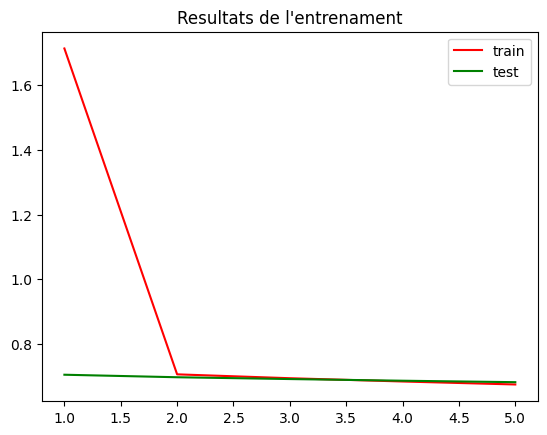

In [104]:
plt.title("Resultats de l'entrenament")
plt.plot(range(1, (epochs + 1)), train_l,  c="red", label="train")
plt.plot(range(1,  (epochs + 1)), test_l,  c="green", label="test")
plt.legend();

In [105]:

from sklearn.metrics import accuracy_score

model.eval() # Posam la xarxa en mode avaluació

targets = []
predictions = []

with torch.no_grad(): # desactiva el càlcul de gradients, no ho necessitam per l'inferència. Estalvia memòria i fa més ràpids els càlculs
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        
        output,_ , _ = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # index amb la max probabilitat
        targets.extend(target.tolist())
        predictions.extend(torch.flatten(pred.cpu()).tolist())
        
targets = np.asarray(targets)
predictions = np.asarray(predictions)

print(f"Accuracy: {accuracy_score(targets, predictions)}")

Accuracy: 0.6028014007003502


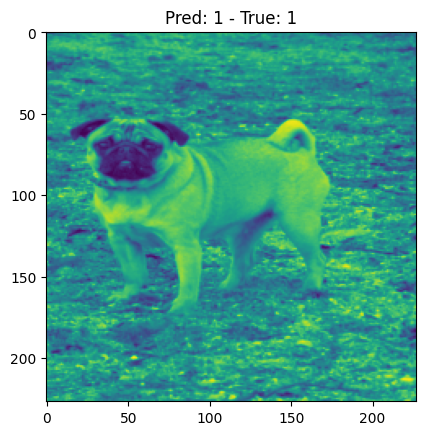

In [106]:
def generador(loader):
    for data, target in val_loader:
        data, target = data.to(device), target.to(device)
        yield data, target

gen = generador(val_loader)

data, true_labels = next(gen)

model.eval()

output, f1, f2 = model(data)

labels = output.detach().cpu().numpy()
images = data.cpu().numpy()
labels = np.argmax(labels, axis=1)

plt.title(f'Pred: {labels[0]} - True: {int(true_labels[0])}')
plt.imshow(images[0,0,:,:]);